<font size=6><center>Multilabel Classification: Predicting Abstract Keywords</center></font>

<center>Author: Aylin Dincer</center>

<center>Date: 2019-04-15</center>

<font size='4'>General Description:</font>

The purpose of this project is to see if it's possible to predict keywords of a scientific paper based on the abstract text.

Publications related to alzheimer's disease was pulled from https://www.ncbi.nlm.nih.gov/pubmed/ and the search criteria was set so all items needed to have an abstract and the associated keywords.  All items in the search was exported as an xml file.

<font size='4'>Script Description</font>

1. Read xml file with pubmed data
2. Grab the abstract title, abstract text, and keywords from the xml
3. Remove rows with any missing data or if they are duplicate publications (with corrections)
4. Preprocess the text to remove any special characters
5. Format keywords for running multilabel classification and remove 'alzheimers disease' as a keyword
6. Pull the 20 most common keywords
7. Remove keywords not listed in the 20 most common list
8. Multilabel classification

<font size='4'>Model Description</font>

This is a classification problem since I want to classify each abstract with a set of keywords. There are many different types of classification algorithms, but a lot of them assume that only one label will be assigned to the sample.  This particular problem would need multiple labels to be assigned, so the multilabel classification seemed like the best choice. With multilabel classification, you are able to assign multiple labels (or keywords) to an instance and there are no contraints on the amount of labels that can be assigned.

Steps needed to perform multilabel classification:
1. Preprocess the keywords by first fitting the keywords to the MultiLabelBinarizer() estimator and later transforming the keywords (training and test set) into a binary matrix.
    - The binary matrix format is needed to run further estimators.
2. Split the data into a training set and a test set
3. Build a vocabulary of words from the abstract text and count how many times each word is used. CountVectorizer estimator used to convert text into a matrix of counts, build a vocabulary of known words, and encode new text.
4. Need to apply the term frequency-inverse document frequency (tf-idf) algorithm all of my abstrac texts.
    - tf-idf is an algorithm for text mining that essentially outputs a weight for each word and evaluates how important the word is to all the documents.  The importance of the word is measured by the number of times the words appear in the one document (term frequency), but is offset by how frequency of the word in all of the documents (inverse-document frequency).  This alogrithm would avoid words such as and, the, I, etc.
5. To predict multiple labels, we use the one-versus-rest algorithm (OneVsRestClassifier).  This algorithm breaks down the problem into multiple independent binary classification.
6. LinearSVC (Linear Support Vector Classification) is wrapped in the OneVsRestClassifier function. This classifier is used for linear classification of large datsets.
7. Compute Hamming loss score: Evaluation for a multilabel classification is a bit different than in a single classification.  Since there is a set of labels (multiple outputs), the set could be fully correct, partially correct, or completely incorrect. For these cases, it is useful to use the hamming loss measure.  Hamming loss is the fraction of incorrect labels over the total number of labels.  The optimal output value is zero.

In [1]:
# Load packages and matplotlib parameters
from bs4 import BeautifulSoup
import pandas as pd
from functools import reduce
import re
import collections
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 11})

In [2]:
# Open xml file and run through BeautifulSoup
infile = open("pubmed_result.xml","r")
contents = infile.read()
soup = BeautifulSoup(contents,'xml')

In [3]:
# Get texts within tags, "ArticleTitle", "Abstract", and "KeywordList", and save in dictionary.
# Some tags were missing within the article. If missing, cell was marked as NA.
article_titles = {}
abstract_texts = {}
keywords = {}
count = 0
for tag in soup.findAll("PubmedArticle"):
    count += 1
    try:
        article_titles[count] = tag.find("ArticleTitle").get_text().lower()
    except AttributeError:
        article_titles[count] = 'NA'
    try:
        abstract_texts[count] = tag.find("Abstract").get_text().lower()
    except AttributeError:
        abstract_texts[count] = 'NA'
    try:
        keywords[count] = tag.find("KeywordList").get_text().lower()
    except AttributeError:
        keywords[count] = 'NA'

print('Length of Article Titles:{} \nLength of Abstracts:{} \nLength of Keywords: {}'.format(len(article_titles), len(abstract_texts), len(keywords)))




Length of Article Titles:16522 
Length of Abstracts:16522 
Length of Keywords: 16522


In [4]:
# Remove keys with NA values or repeats of abstracts that were corrected
def removeNA(dictionary):
    for num, data in list(dictionary.items()):
        if data == 'NA':
            article_titles.pop(num)
            abstract_texts.pop(num)
            keywords.pop(num)
            
def removeString(dictionary, string):
    for num, data in list(dictionary.items()):
        if string in data:
            article_titles.pop(num)
            abstract_texts.pop(num)
            keywords.pop(num)

removeNA(article_titles)
removeNA(abstract_texts)
removeNA(keywords)
removeString(article_titles, 'corrigendum')
removeString(abstract_texts, 'this corrects the article on')

print('Length of Article Titles:{} \nLength of Abstracts:{} \nLength of Keywords: {}'.format(len(article_titles), len(abstract_texts), len(keywords)))

Length of Article Titles:16508 
Length of Abstracts:16508 
Length of Keywords: 16508


In [5]:
# Covert each dictionary into a pandas data frame and merge on the column Number.
df_article_titles = pd.DataFrame(list(article_titles.items()), columns=['Number', 'Article_Titles'])
df_abstract_texts = pd.DataFrame(list(abstract_texts.items()), columns=['Number', 'Abstract_Texts'])
df_keywords = pd.DataFrame(list(keywords.items()), columns=['Number', 'Keywords'])

all_df = [df_article_titles, df_abstract_texts, df_keywords]
pubmed_data = reduce(lambda left,right: pd.merge(left,right,on='Number'), all_df)
pubmed_data.head(10)

,Number,Article_Titles,Abstract_Texts,Keywords
0,1,"design, synthesis and evaluation of a novel me...",\na series of compounds following the lead com...,\nacetylcholinesterase inhibitors\nalzheimer's...
1,2,mutation and association analyses of dementia-...,\nalzheimer's disease (ad) is the most common ...,\nalzheimer's disease\nassociation\ndementia\n...
2,3,chronic cerebral hypoperfusion upregulates lep...,\nalzheimer's disease (ad) is the most common ...,\nakt protein\nalzheimer’s disease\ncerebral i...
3,4,neuro-inflammation and anti-inflammatory treat...,\nalzheimer's disease (ad) is a neurodegenerat...,\nalzheimer's disease\ninflammation\nnsaids\nt...
4,5,plasma amyloid beta levels and platelet mitoch...,\naltered amyloid metabolism and mitochondrial...,\nalzheimer's disease\namyloid beta\nmitochond...
5,6,profiling sentence repetition deficits in prim...,\nthe use of sentence repetition tasks to dist...,\nalzheimer’s disease. sentence repetition\nlo...
6,7,the cyanobacterial neurotoxin β-n-methylamino-...,\nthe neurotoxin β-n-methylamino-l-alanine rep...,\nalzheimer's disease\namyloid precursor prote...
7,8,search for biomarkers of alzheimer's disease: ...,\ndue to the trend of prolonged lifespan leadi...,\nalzheimer’s disease\nbiomarker\nblood plasma...
8,9,health-promoting self-care in family caregiver...,\nfamily carers often experience difficulties ...,\nalzheimer’s disease\ndisease prevention\nhea...
9,10,exploiting microglial and peripheral immune ce...,\nneuroinflammation is considered one of the c...,\nadaptive immunity\nalzheimer’s disease\ncyto...


In [6]:
# Before preprocessing all columns, specific changes need to be done.
# Keywords Column:
pubmed_data['Keywords'] = [re.sub(r'\n', ',', row) for row in pubmed_data['Keywords']]
pubmed_data['Keywords'] = [re.sub(r'\*', ',', row) for row in pubmed_data['Keywords']]
pubmed_data['Keywords'] = [re.sub(r',,', ',', row) for row in pubmed_data['Keywords']]
pubmed_data['Keywords'] = [re.sub(r'^,|,$', '', row) for row in pubmed_data['Keywords']]

#Article_Titles Column:
pubmed_data['Article_Titles'] = [re.sub(r',', ' ', row) for row in pubmed_data['Article_Titles']]

#Abstract_Texts Column:
pubmed_data['Abstract_Texts'] = [re.sub(r',', ' ', row) for row in pubmed_data['Abstract_Texts']]
pubmed_data.head(10)

,Number,Article_Titles,Abstract_Texts,Keywords
0,1,design synthesis and evaluation of a novel me...,\na series of compounds following the lead com...,"acetylcholinesterase inhibitors,alzheimer's di..."
1,2,mutation and association analyses of dementia-...,\nalzheimer's disease (ad) is the most common ...,"alzheimer's disease,association,dementia,mutat..."
2,3,chronic cerebral hypoperfusion upregulates lep...,\nalzheimer's disease (ad) is the most common ...,"akt protein,alzheimer’s disease,cerebral ische..."
3,4,neuro-inflammation and anti-inflammatory treat...,\nalzheimer's disease (ad) is a neurodegenerat...,"alzheimer's disease,inflammation,nsaids,treatment"
4,5,plasma amyloid beta levels and platelet mitoch...,\naltered amyloid metabolism and mitochondrial...,"alzheimer's disease,amyloid beta,mitochondria,..."
5,6,profiling sentence repetition deficits in prim...,\nthe use of sentence repetition tasks to dist...,"alzheimer’s disease. sentence repetition,logop..."
6,7,the cyanobacterial neurotoxin β-n-methylamino-...,\nthe neurotoxin β-n-methylamino-l-alanine rep...,"alzheimer's disease,amyloid precursor protein,..."
7,8,search for biomarkers of alzheimer's disease: ...,\ndue to the trend of prolonged lifespan leadi...,"alzheimer’s disease,biomarker,blood plasma,cer..."
8,9,health-promoting self-care in family caregiver...,\nfamily carers often experience difficulties ...,"alzheimer’s disease,disease prevention,health,..."
9,10,exploiting microglial and peripheral immune ce...,\nneuroinflammation is considered one of the c...,"adaptive immunity,alzheimer’s disease,cytokine..."


In [7]:
# Preprocessing for all columns
def data_preprocessing(txt):
    txt = txt.lower()
    txt = re.sub(r"[\(\[].*?[\)\]]", '', txt)
    txt = re.sub(r'\.(?!\d)', ' ', txt)
    txt = re.sub(r':', ' ', txt)
    txt = re.sub(r"’", "\'", txt)    
    txt = re.sub(r"what's", "what is ", txt)
    txt = re.sub(r"\'s", " ", txt)    
    txt = re.sub(r"\'ve", " have ", txt)
    txt = re.sub(r"can't", "can not ", txt)
    txt = re.sub(r"n't", " not ", txt)
    txt = re.sub(r"i'm", "i am ", txt)
    txt = re.sub(r"\'re", " are ", txt)
    txt = re.sub(r"\'d", " would ", txt)
    txt = re.sub(r"\'ll", " will ", txt)
    txt = re.sub(r"\'scuse", " excuse ", txt)
    txt = re.sub('-', ' ', txt)
    txt = re.sub('\'', ' ', txt)
    txt = re.sub('\"', ' ', txt)
    txt = re.sub('\s+', ' ', txt)
    txt = re.sub(r'β', 'beta', txt)
    txt = re.sub(r'ß', 'beta', txt)
    txt = re.sub(r'γ', 'gamma', txt)
    txt = re.sub(r'μ', 'mu', txt)
    txt = re.sub(r'α', 'alpha', txt)
    txt = re.sub(r'ω', 'omega', txt)
    txt = re.sub(r'\bad\b', 'alzheimers disease', txt)
    txt = re.sub(r'alzheimer disease', 'alzheimers disease', txt)
    txt = re.sub(r'amyloid beta', 'amyloid', txt)
    txt = re.sub(r'beta amyloid', 'amyloid', txt)
    txt = re.sub(r'\babeta\b', 'amyloid', txt)
    txt = re.sub(r'amyloid beta protein', 'amyloid', txt)
    txt = re.sub(r'magnetic resonance imaging', 'mri', txt)
    txt = re.sub(r'positron emission tomography', 'pet', txt)
    txt = re.sub(r'apolipoprotein e', 'apoe', txt)
    txt = re.sub(r'cognitive function', ' cognition', txt)
    txt = re.sub(r'tau protein', ' tau', txt)
    txt = re.sub(r'tauopathies', ' tauopathy', txt)
    txt = re.sub(r'\bmci\b', ' mild cognitive impairement', txt)
    txt = re.sub(r'amyloid precursor protein', ' app', txt)
    txt = re.sub(r'mild cognitive impairement', ' mild cognitive impairment', txt)
    txt = re.sub(r'f18', ' 18f', txt)
    txt = re.sub(r'f 18', ' 18f', txt)
    txt = re.sub(r'18 f', ' 18f', txt)
    txt = re.sub(r'c11', ' 11c', txt)
    txt = re.sub(r'c 11', ' 11c', txt)
    txt = re.sub(r'11 c', ' 11c', txt)
    txt = re.sub(r'introduction', ' ', txt)
    txt = re.sub(r'\s([?.,!"](?:\s|$))', r'\1', txt)
    txt = txt.split('copyright', 1)[0]
    txt = txt.strip()
    return txt

pubmed_data['Article_Titles'] = pubmed_data['Article_Titles'].map(lambda row : data_preprocessing(row))
pubmed_data['Abstract_Texts'] = pubmed_data['Abstract_Texts'].map(lambda row : data_preprocessing(row))
pubmed_data['Keywords'] = pubmed_data['Keywords'].map(lambda row : data_preprocessing(row))

# Make sure all special characters are removed.
pubmed_data['Keywords'] = [re.sub(r'[^A-Za-z0-9, ]+', '', row) for row in pubmed_data['Keywords']]
pubmed_data['Article_Titles'] = [re.sub(r'[^A-Za-z0-9\. ]+', '', row) for row in pubmed_data['Article_Titles']]
pubmed_data['Abstract_Texts'] = [re.sub(r'[^A-Za-z0-9\. ]+', '', row) for row in pubmed_data['Abstract_Texts']]
pubmed_data.head(10)

,Number,Article_Titles,Abstract_Texts,Keywords
0,1,design synthesis and evaluation of a novel met...,a series of compounds following the lead compo...,"acetylcholinesterase inhibitors,alzheimers dis..."
1,2,mutation and association analyses of dementia ...,alzheimers disease is the most common cause of...,"alzheimers disease,association,dementia,mutati..."
2,3,chronic cerebral hypoperfusion upregulates lep...,alzheimers disease is the most common type of ...,"akt protein,alzheimers disease,cerebral ischem..."
3,4,neuro inflammation and anti inflammatory treat...,alzheimers disease is a neurodegenerative dise...,"alzheimers disease,inflammation,nsaids,treatment"
4,5,plasma amyloid levels and platelet mitochondri...,altered amyloid metabolism and mitochondrial d...,"alzheimers disease,amyloid,mitochondria,plasma..."
5,6,profiling sentence repetition deficits in prim...,the use of sentence repetition tasks to distin...,"alzheimers disease sentence repetition,logopen..."
6,7,the cyanobacterial neurotoxin beta n methylami...,the neurotoxin beta n methylamino l alanine re...,"alzheimers disease, app,glypican 1,heparan sul..."
7,8,search for biomarkers of alzheimers disease re...,due to the trend of prolonged lifespan leading...,"alzheimers disease,biomarker,blood plasma,cere..."
8,9,health promoting self care in family caregiver...,family carers often experience difficulties ma...,"alzheimers disease,disease prevention,health,h..."
9,10,exploiting microglial and peripheral immune ce...,neuroinflammation is considered one of the car...,"adaptive immunity,alzheimers disease,cytokines..."


In [8]:
# Combine the Article_Titles Column and the Abstract Texts column together (Major topic is usually described in title)
pubmed_data['Abstract_Texts'] = pubmed_data['Article_Titles'] + ' ' + pubmed_data['Abstract_Texts']
pubmed_data.head(10)

,Number,Article_Titles,Abstract_Texts,Keywords
0,1,design synthesis and evaluation of a novel met...,design synthesis and evaluation of a novel met...,"acetylcholinesterase inhibitors,alzheimers dis..."
1,2,mutation and association analyses of dementia ...,mutation and association analyses of dementia ...,"alzheimers disease,association,dementia,mutati..."
2,3,chronic cerebral hypoperfusion upregulates lep...,chronic cerebral hypoperfusion upregulates lep...,"akt protein,alzheimers disease,cerebral ischem..."
3,4,neuro inflammation and anti inflammatory treat...,neuro inflammation and anti inflammatory treat...,"alzheimers disease,inflammation,nsaids,treatment"
4,5,plasma amyloid levels and platelet mitochondri...,plasma amyloid levels and platelet mitochondri...,"alzheimers disease,amyloid,mitochondria,plasma..."
5,6,profiling sentence repetition deficits in prim...,profiling sentence repetition deficits in prim...,"alzheimers disease sentence repetition,logopen..."
6,7,the cyanobacterial neurotoxin beta n methylami...,the cyanobacterial neurotoxin beta n methylami...,"alzheimers disease, app,glypican 1,heparan sul..."
7,8,search for biomarkers of alzheimers disease re...,search for biomarkers of alzheimers disease re...,"alzheimers disease,biomarker,blood plasma,cere..."
8,9,health promoting self care in family caregiver...,health promoting self care in family caregiver...,"alzheimers disease,disease prevention,health,h..."
9,10,exploiting microglial and peripheral immune ce...,exploiting microglial and peripheral immune ce...,"adaptive immunity,alzheimers disease,cytokines..."


In [9]:
# For multi label modeling, the keywords need to be in a list format.
pubmed_data['Keywords'] = [pubmed_data['Keywords'][i].split(',') for i in range(len(pubmed_data))]

# Make sure there is no spaces in the empty elements. Example: ' ' -> ''
for i in range(len(pubmed_data)):
    for j, word in enumerate(pubmed_data['Keywords'][i]):
        pubmed_data['Keywords'][i][j] = pubmed_data['Keywords'][i][j].strip()
        
# Mark None for the the keyword, alzheimers disease, since almost all the abstracts have as keyword.
# Mark None for the empty elements '' 
for i in range(len(pubmed_data)):
    for j, word in enumerate(pubmed_data['Keywords'][i]):
        if word == 'alzheimers disease':
            pubmed_data['Keywords'][i][j] = None
        if word == '':
            pubmed_data['Keywords'][i][j] = None
pubmed_data.head(10)

,Number,Article_Titles,Abstract_Texts,Keywords
0,1,design synthesis and evaluation of a novel met...,design synthesis and evaluation of a novel met...,"[acetylcholinesterase inhibitors, None, defera..."
1,2,mutation and association analyses of dementia ...,mutation and association analyses of dementia ...,"[None, association, dementia, mutation, next g..."
2,3,chronic cerebral hypoperfusion upregulates lep...,chronic cerebral hypoperfusion upregulates lep...,"[akt protein, None, cerebral ischemia, leptin ..."
3,4,neuro inflammation and anti inflammatory treat...,neuro inflammation and anti inflammatory treat...,"[None, inflammation, nsaids, treatment]"
4,5,plasma amyloid levels and platelet mitochondri...,plasma amyloid levels and platelet mitochondri...,"[None, amyloid, mitochondria, plasma, platelet]"
5,6,profiling sentence repetition deficits in prim...,profiling sentence repetition deficits in prim...,"[alzheimers disease sentence repetition, logop..."
6,7,the cyanobacterial neurotoxin beta n methylami...,the cyanobacterial neurotoxin beta n methylami...,"[None, app, glypican 1, heparan sulfate, neuro..."
7,8,search for biomarkers of alzheimers disease re...,search for biomarkers of alzheimers disease re...,"[None, biomarker, blood plasma, cerebrospinal ..."
8,9,health promoting self care in family caregiver...,health promoting self care in family caregiver...,"[None, disease prevention, health, health prom..."
9,10,exploiting microglial and peripheral immune ce...,exploiting microglial and peripheral immune ce...,"[adaptive immunity, None, cytokines, innate im..."


In [10]:
# Remove None from list.  If None is the only thing in the list, create an empty list
pubmed_data['Keywords'] = [list(filter(None, pubmed_data['Keywords'][i])) for i in range(len(pubmed_data))]
pubmed_data.head(10)

,Number,Article_Titles,Abstract_Texts,Keywords
0,1,design synthesis and evaluation of a novel met...,design synthesis and evaluation of a novel met...,"[acetylcholinesterase inhibitors, deferasirox,..."
1,2,mutation and association analyses of dementia ...,mutation and association analyses of dementia ...,"[association, dementia, mutation, next generat..."
2,3,chronic cerebral hypoperfusion upregulates lep...,chronic cerebral hypoperfusion upregulates lep...,"[akt protein, cerebral ischemia, leptin recept..."
3,4,neuro inflammation and anti inflammatory treat...,neuro inflammation and anti inflammatory treat...,"[inflammation, nsaids, treatment]"
4,5,plasma amyloid levels and platelet mitochondri...,plasma amyloid levels and platelet mitochondri...,"[amyloid, mitochondria, plasma, platelet]"
5,6,profiling sentence repetition deficits in prim...,profiling sentence repetition deficits in prim...,"[alzheimers disease sentence repetition, logop..."
6,7,the cyanobacterial neurotoxin beta n methylami...,the cyanobacterial neurotoxin beta n methylami...,"[app, glypican 1, heparan sulfate, neuronal ce..."
7,8,search for biomarkers of alzheimers disease re...,search for biomarkers of alzheimers disease re...,"[biomarker, blood plasma, cerebrospinal fluid,..."
8,9,health promoting self care in family caregiver...,health promoting self care in family caregiver...,"[disease prevention, health, health promotion,..."
9,10,exploiting microglial and peripheral immune ce...,exploiting microglial and peripheral immune ce...,"[adaptive immunity, cytokines, innate immunity..."


Text(0,0.5,'Number of Keywords')

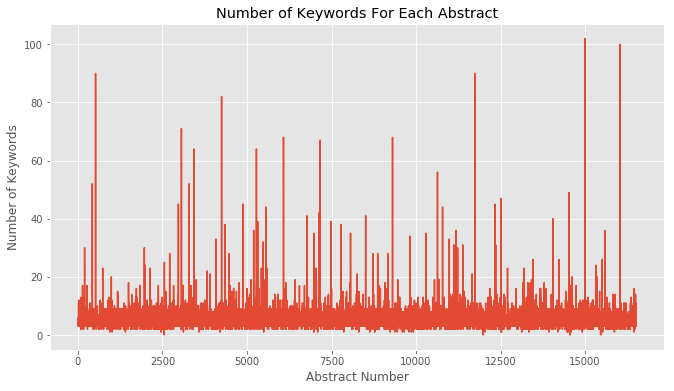

In [11]:
nelements = [len(pubmed_data['Keywords'][i]) for i in range(len(pubmed_data['Keywords']))]

fig = plt.figure(figsize=(11, 6))
ax = plt.axes()

plt.plot(range(len(pubmed_data['Keywords'])), nelements)
ax.set_title("Number of Keywords For Each Abstract")
ax.set_xlabel("Abstract Number")
ax.set_ylabel("Number of Keywords")

In [12]:
# Generate a list of all the keywords 
keywords_list = []
for i in range(len(pubmed_data)):
    keywords_list = keywords_list + pubmed_data['Keywords'][i]

# Counts for each unique keyword
counter=collections.Counter(keywords_list)
print('Number of total unique keywords: {}'.format(len(counter)))

# Pull the 20 most common words
most_common_words= [word for word, word_count in collections.Counter(keywords_list).most_common(20)]
print('20 most common keywords: {}'.format(most_common_words))

Number of total unique keywords: 25224
20 most common keywords: ['amyloid', 'dementia', 'mild cognitive impairment', 'tau', 'neurodegeneration', 'parkinson disease', 'cognition', 'mri', 'aging', 'neuroinflammation', 'biomarkers', 'oxidative stress', 'hippocampus', 'cerebrospinal fluid', 'apoe', 'microglia', 'pet', 'memory', 'app', 'inflammation']


Text(0,0.5,'Keywords')

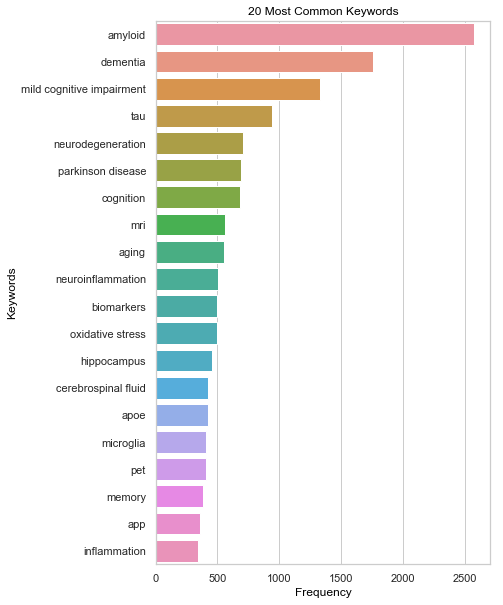

In [13]:
# Plot the frequency for the most common keywords

# Sort keywords from most used to least
sorted_counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)
sorted_keywords, sorted_freq = zip(*sorted_counter)
sorted_keywords = sorted_keywords[:20]
sorted_freq = sorted_freq[:20]

# Using seaborn package
sns.set(style="whitegrid")
fig = plt.figure(figsize=(6, 10))
ax = plt.axes()

sns.barplot(sorted_freq, np.array(sorted_keywords))
plt.title('20 Most Common Keywords', color = 'black')
ax.set_xlabel('Frequency', color = 'black')
ax.set_ylabel('Keywords', color = 'black')

In [14]:
# Keep only the most common keywords and if abstract doesn't include any of the common keywords, remove completely
for i in range(len(pubmed_data)):
    for j, word in enumerate(pubmed_data['Keywords'][i]):
        if word not in most_common_words:
            pubmed_data['Keywords'][i][j] = None
                 
pubmed_data['Keywords'] = [list(filter(None, pubmed_data['Keywords'][i])) for i in range(len(pubmed_data))]
pubmed_data = pubmed_data[pubmed_data['Keywords'].map(lambda d: len(d)) > 0]
pubmed_data.reset_index(inplace = True, drop = True)

print('Number of total abstracts after removal: {}'.format(len(pubmed_data)))

Number of total abstracts after removal: 9507


In [15]:
# Packages used for ML
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import hamming_loss

In [16]:
# Load data
X = np.array(pubmed_data['Abstract_Texts'])
y = pubmed_data['Keywords']

# MultiLabelBinarizer is used to transform the keywords to a binary matrix for multilabel modeling
# Fit all labels to binarizer
mlb = MultiLabelBinarizer().fit(y)

# Split data into a features matrix and target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 9000)

# Transform train and test keywords into the binary matrix format
y_train_binary = mlb.transform(y_train)
y_test_binary = mlb.transform(y_test)
print('y_train_binary shape: {} \ny_test_binary shape: {}'.format(y_train_binary.shape, y_test_binary.shape))
print()
print('y_train_binary array: \n{}'.format(y_train_binary[:10]))




y_train_binary shape: (7605, 20) 
y_test_binary shape: (1902, 20)

y_train_binary array: 
[[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]


In [17]:
# Instantiate CountVectorizer
vectorizer = CountVectorizer(analyzer = 'word', strip_accents = 'unicode', stop_words = 'english', max_df = 0.85)

# Fit and transform the training abstract text and transform the test abstract text
X_train_tok = vectorizer.fit_transform(X_train)
X_test_tok = vectorizer.transform(X_test)

print('X_train_tok shape: {} \nX_test_tok shape: {}'.format(X_train_tok.shape, X_test_tok.shape))
print()
print('Feature names: \n{}'.format(vectorizer.get_feature_names()))



X_train_tok shape: (7605, 31182) 
X_test_tok shape: (1902, 31182)

Feature names: 
['00', '000', '00001', '00002', '0001', '0002', '0003', '0007', '000784', '0008', '0009', '001', '00175', '0018', '001qs', '002', '002976', '003', '0038', '003882', '003916', '004', '004499', '005', '006', '0060609', '007', '0079', '008', '00845', '009', '0091', '00e', '01', '010', '011', '013', '014', '015', '016', '017', '0173', '019', '01mol', '02', '020', '021', '022', '023', '024', '02444', '025', '026', '027', '028', '0281', '03', '030', '031', '033', '034', '035', '037', '038', '039', '0396', '04', '040', '043', '044', '045', '046', '047', '049', '05', '050', '0513', '052', '053', '054', '055', '056', '0563', '06', '062', '063', '064', '066', '067', '069', '06m', '07', '071', '073', '074', '077', '0779', '078', '079', '08', '080', '083', '084', '084donepezil', '087', '088', '09', '091', '092', '094', '096', '097', '099', '0iii', '0ol22', '10', '100', '1000', '1000nm', '1000s', '1005', '100635', '1

In [18]:
# Transform a count matrix to a normalized tf or tf-idf representation
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tok)
X_test_tfidf = tfidf_transformer.transform(X_test_tok)

print('X_train_tfidf shape: {} \nX_test_tfidf shape: {}'.format(X_train_tfidf.shape, X_test_tfidf.shape))
print()
print('tf-idf representation: \n{}'.format(X_train_tfidf.data[:30]))

X_train_tfidf shape: (7605, 31182) 
X_test_tfidf shape: (1902, 31182)

tf-idf representation: 
[0.06068672 0.05844884 0.06436414 0.07626674 0.05095658 0.0359008
 0.04880223 0.05473296 0.06660257 0.13986347 0.10340482 0.043465
 0.06021853 0.05086061 0.05252498 0.06674159 0.0664194  0.06340515
 0.05382011 0.0681171  0.13623419 0.04631216 0.06900864 0.05213227
 0.05327104 0.03948387 0.08021854 0.11436929 0.05456213 0.09443514]


In [19]:
# Look at the C parameter
clf = OneVsRestClassifier(LinearSVC(max_iter=7000))
clf.fit(X_train_tfidf,y_train_binary)
y_preds_binary = clf.predict(X_test_tfidf)

actual_key = mlb.inverse_transform(y_test_binary)[1:30]
predicted_key = mlb.inverse_transform(y_preds_binary)[1:30]

print("Standard training set score: {:.3f}".format(clf.score(X_train_tfidf, y_train_binary)))
print("Standard test set score: {:.3f}".format(clf.score(X_test_tfidf, y_test_binary)))
print("Hamming loss measure: {:.10f}".format(hamming_loss(y_test_binary,y_preds_binary)))

print()
count = 0
print('Actual labels:')
for label in actual_key:
    count += 1
    print(count, label)
    
print()

count = 0
print('Predicted labels:')
for label in predicted_key:
    count +=1
    print(count, label)

Standard training set score: 0.929
Standard test set score: 0.330
Hamming loss measure: 0.0550736067

Actual labels:
1 ('dementia', 'mild cognitive impairment', 'mri')
2 ('inflammation', 'microglia')
3 ('amyloid',)
4 ('amyloid',)
5 ('mild cognitive impairment',)
6 ('aging', 'amyloid')
7 ('tau',)
8 ('amyloid', 'apoe', 'neuroinflammation')
9 ('cognition',)
10 ('parkinson disease',)
11 ('amyloid',)
12 ('cognition',)
13 ('amyloid', 'pet', 'tau')
14 ('mild cognitive impairment', 'mri')
15 ('tau',)
16 ('cognition', 'memory')
17 ('dementia', 'mri')
18 ('mild cognitive impairment',)
19 ('mild cognitive impairment',)
20 ('parkinson disease',)
21 ('app',)
22 ('memory',)
23 ('dementia', 'mild cognitive impairment')
24 ('microglia',)
25 ('amyloid',)
26 ('neuroinflammation',)
27 ('tau',)
28 ('apoe',)
29 ('tau',)

Predicted labels:
1 ('mild cognitive impairment', 'mri')
2 ('amyloid',)
3 ()
4 ()
5 ('mild cognitive impairment', 'mri')
6 ('aging',)
7 ()
8 ('amyloid', 'apoe', 'tau')
9 ()
10 ('neurodegen

Conclusion: It looks like it is somewhat possible to predict keywords. The blank predictions could be for multiple reasons 1) insufficient data for some of the keywords 2) cleanup text further 3) may need to resample the data 4) may not be able to predict keywords just on the abstract - may need full paper. 

Text(0,0.5,'Keywords')

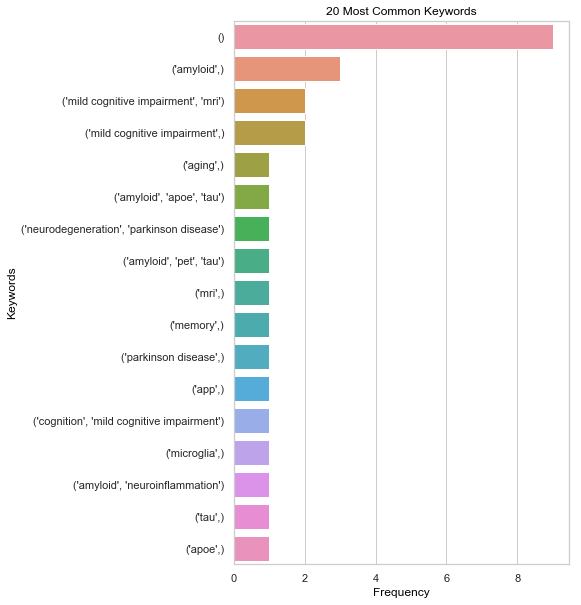

In [20]:
nelements = [len(predicted_key[i]) for i in range(len(predicted_key))]

# Counts for each unique keyword
counter=collections.Counter(predicted_key)

# Sort keywords from most used to least
sorted_counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)
sorted_keywords, sorted_freq = zip(*sorted_counter)
sorted_keywords = sorted_keywords[:20]
sorted_freq = sorted_freq[:20]

# Using seaborn package
sns.set(style="whitegrid")
fig = plt.figure(figsize=(6, 10))
ax = plt.axes()

sns.barplot(sorted_freq, np.array(sorted_keywords))
plt.title('20 Most Common Keywords', color = 'black')
ax.set_xlabel('Frequency', color = 'black')
ax.set_ylabel('Keywords', color = 'black')

In [21]:
# More efficient method with the exact output

classifier2 = Pipeline([
    ('vectorizer', CountVectorizer(analyzer = 'word', strip_accents = 'unicode', stop_words = 'english', max_df = 0.85)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC(max_iter=7000)))])

classifier2 = classifier2.fit(X_train, y_train_binary)
y_preds_binary_2 = classifier2.predict(X_test)

actual_2 = mlb.inverse_transform(y_test_binary)[1:30]
predicted_2 = mlb.inverse_transform(y_preds_binary_2)[1:30]

print("Standard training set score: {:.3f}".format(classifier2.score(X_train, y_train_binary)))
print("Standard test set score: {:.3f}".format(classifier2.score(X_test, y_test_binary)))
print("Hamming loss measure: {:.10f}".format(hamming_loss(y_test_binary,y_preds_binary_2)))

print()
count = 0
print('Actual labels:')
for label in actual_2:
    count += 1
    print(count, label)
    
print()

count = 0
print('Predicted labels:')
for label in predicted_2:
    count +=1
    print(count, label)

Standard training set score: 0.929
Standard test set score: 0.330
Hamming loss measure: 0.0550736067

Actual labels:
1 ('dementia', 'mild cognitive impairment', 'mri')
2 ('inflammation', 'microglia')
3 ('amyloid',)
4 ('amyloid',)
5 ('mild cognitive impairment',)
6 ('aging', 'amyloid')
7 ('tau',)
8 ('amyloid', 'apoe', 'neuroinflammation')
9 ('cognition',)
10 ('parkinson disease',)
11 ('amyloid',)
12 ('cognition',)
13 ('amyloid', 'pet', 'tau')
14 ('mild cognitive impairment', 'mri')
15 ('tau',)
16 ('cognition', 'memory')
17 ('dementia', 'mri')
18 ('mild cognitive impairment',)
19 ('mild cognitive impairment',)
20 ('parkinson disease',)
21 ('app',)
22 ('memory',)
23 ('dementia', 'mild cognitive impairment')
24 ('microglia',)
25 ('amyloid',)
26 ('neuroinflammation',)
27 ('tau',)
28 ('apoe',)
29 ('tau',)

Predicted labels:
1 ('mild cognitive impairment', 'mri')
2 ('amyloid',)
3 ()
4 ()
5 ('mild cognitive impairment', 'mri')
6 ('aging',)
7 ()
8 ('amyloid', 'apoe', 'tau')
9 ()
10 ('neurodegen